In [9]:


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from typing import Optional, Union, Tuple
from pyod.models.auto_encoder_torch import AutoEncoder
from matplotlib import cm

class MultiTimeSeriesAutoencoder:
    def __init__(self,
                 df: pd.DataFrame,
                 time_col: str,
                 feature: str,
                 slice_col: str = "slice_id",
                 model_params: Optional[dict] = None,
                 external_model: Optional[object] = None,
                 scaler: Union[str, object, None] = "None",
                 threshold_percentile: float = 99):
        self.df_raw = df.copy()
        self.time_col = time_col
        self.feature = feature
        self.slice_col = slice_col
        self.model_params = model_params
        self.external_model = external_model
        self.scaler_type = scaler
        self.scaler = None
        self.model = None
        self.threshold_percentile = threshold_percentile

        self.input_tensor = None
        self.input_tensor_scaled = None
        self.anomaly_scores = None
        self.threshold_scores = None

    def _build_tensor_from_slices(self):
        grouped = self.df_raw.groupby(self.slice_col)
        tensors = []

        for _, group in grouped:
            series = group.sort_values(by=self.time_col)[self.feature].values
            tensors.append(series)

        tensor_3d = np.stack(tensors)[:, :, np.newaxis]  # shape: (n_samples, n_timesteps, 1)
        return tensor_3d

    def _apply_scaler(self, X: np.ndarray) -> np.ndarray:
        if self.scaler_type is None:
            return X
        flat_X = X.reshape(-1, X.shape[-1])  # flatten across time axis
        if self.scaler_type == "standard":
            self.scaler = StandardScaler()
        elif self.scaler_type == "minmax":
            from sklearn.preprocessing import MinMaxScaler
            self.scaler = MinMaxScaler()
        else:
            self.scaler = self.scaler_type
        scaled_flat = self.scaler.fit_transform(flat_X)
        return scaled_flat.reshape(X.shape)

    def prepare(self):
        tensor = self._build_tensor_from_slices()
        self.input_tensor = tensor
        self.input_tensor_scaled = self._apply_scaler(tensor)

    def _init_model(self):
        if self.external_model:
            return self.external_model
        default_params = {
            "hidden_neurons": [self.input_tensor.shape[1], 32, 32, self.input_tensor.shape[1]],
            "hidden_activation": "relu",
            "epochs": 20,
            "batch_norm": True,
            "learning_rate": 0.001,
            "batch_size": 32,
            "dropout_rate": 0.2,
        }
        if self.model_params:
            default_params.update(self.model_params)
        return AutoEncoder(**default_params)

    def fit(self, threshold_percentile=None):
        if self.input_tensor_scaled is None:
            raise ValueError("Call prepare() before fit().")
        if threshold_percentile is None:
            threshold_percentile = self.threshold_percentile

        n_samples = self.input_tensor_scaled.shape[0]
        X = self.input_tensor_scaled.reshape(n_samples, -1)  # flatten to 2D for sklearn-compatible model
        self.model = self._init_model()
        self.model.fit(X)

        self.anomaly_scores = self.model.decision_scores_
        self.threshold_scores = np.percentile(self.anomaly_scores, threshold_percentile)

    def get_anomaly_stats(self):
        """
        Return anomaly scores and labels per slice (1 row per slice_id).

        Returns
        -------
        pd.DataFrame
            A DataFrame with columns ['sn', slice_col, 'anomaly_score', 'is_outlier']
        """
        if self.anomaly_scores is None:
            raise ValueError("Call fit() first.")

        is_outlier = self.anomaly_scores > self.threshold_scores

        unique_slices = self.df_raw[[self.slice_col]].drop_duplicates().reset_index(drop=True)
        result_df = unique_slices.copy()
        result_df["anomaly_score"] = self.anomaly_scores
        result_df["is_outlier"] = is_outlier
        result_df["sn"] = result_df[self.slice_col].apply(lambda x: str(x).split("_")[0])

        return result_df[["sn", self.slice_col, "anomaly_score", "is_outlier"]]

    def predict_score_and_label(self, input_array: np.ndarray, threshold: float = None):
        """
        Predict anomaly scores and labels for new data.

        Parameters
        ----------
        input_array : np.ndarray
            Array of shape (n_samples, n_lags) matching the model's input structure.
        threshold : float, optional
            Manual threshold for outlier decision. If None, uses trained `self.threshold_scores`.

        Returns
        -------
        dict
            {
                "anomaly_scores": np.ndarray,
                "is_outlier": np.ndarray (bool)
            }
        """
        if self.model is None:
            raise ValueError("Model is not trained. Call fit() first.")
        
        # Optionally scale input
        if self.scaler:
            input_array = self.scaler.transform(input_array)
        
        scores = self.model.decision_function(input_array)

        if threshold is None:
            if self.threshold_scores is None:
                raise ValueError("Threshold not defined. Either provide it or call fit() first.")
            threshold = self.threshold_scores

        is_outlier = scores > threshold

        return {
            "b ": scores,
            "is_outlier": is_outlier
        }

    def predict_and_compare_with_normal(self,
                                        input_array: np.ndarray,
                                        title_id: str = "",
                                        n_normal_samples: int = 100,
                                        normal_score_range: Optional[Tuple[float, float]] = None):
        """
        Predict anomaly score of an input time series and compare it with normal training samples.

        Parameters
        ----------
        input_array : np.ndarray
            Shape (1, time_steps). The new time series to evaluate.
        title_id : str
            Identifier for labeling the input series on the plot.
        n_normal_samples : int
            Number of normal training series to plot for comparison.
        normal_score_range : tuple, optional
            If provided, defines (min_score, max_score) range to select normal samples
            from the training data. Overrides threshold-based selection.
        """
        if self.model is None or self.anomaly_scores is None:
            raise ValueError("Model not trained. Call fit() first.")

        # Ensure 2D shape for input
        if input_array.ndim == 1:
            input_array = input_array.reshape(1, -1)

        if self.scaler:
            input_array_scaled = self.scaler.transform(input_array)
        else:
            input_array_scaled = input_array

        scores = self.model.decision_function(input_array_scaled)
        labels = scores > self.threshold_scores

        # Select normal samples from training
        scores_all = self.anomaly_scores
        if normal_score_range is not None:
            min_score, max_score = normal_score_range
            normal_idx = np.where((scores_all >= min_score) & (scores_all <= max_score))[0]
        else:
            normal_idx = np.where(scores_all <= self.threshold_scores)[0]

        sample_n_normal = min(n_normal_samples, len(normal_idx))
        if sample_n_normal == 0:
            raise ValueError("No normal samples found in the specified range.")

        selected_idx = np.random.choice(normal_idx, size=sample_n_normal, replace=False)
        normal_samples = self.input_tensor[selected_idx, :, 0]

        # Plot
        plt.figure(figsize=(12, 5))
        cmap = cm.get_cmap('viridis', sample_n_normal)
        for i, series in enumerate(normal_samples):
            plt.plot(series, color=cmap(i), alpha=0.5)

        # Plot the input series
        input_series = input_array[0]
        label = 'Abnormal' if labels[0] else 'Normal'
        color = 'red' if labels[0] else 'darkgreen'
        plt.plot(input_series, linewidth=2.5, color=color, label=f"Input Series")

        # Add annotation in bottom-right
        annotation = (f"Score: {scores[0]:.4f}\n"
                    f"Thresh: {self.threshold_scores:.4f}\n"
                    f"Outlier: {label}")
        plt.annotate(annotation,
                    xy=(1.0, 0.0), xycoords='axes fraction',
                    xytext=(-10, 10), textcoords='offset points',
                    ha='right', va='bottom',
                    fontsize=9,
                    bbox=dict(boxstyle="round", fc="white", ec=color, alpha=0.8))

        plt.title(f"Comparison of Input Series with Normal Samples")
        plt.xlabel("Time Index")
        plt.ylabel(self.feature)
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    def plot_anomaly_score_distribution(self, bins=30, sample_size=10000, random_state=42):
        """
        Plot the distribution of anomaly scores (with optional downsampling).

        Parameters
        ----------
        bins : int
            Number of histogram bins (default=30).
        sample_size : int
            Number of scores to sample for plotting. If the total number of scores is less than this, use all.
        random_state : int
            Seed for reproducible sampling.
        """
        if self.anomaly_scores is None:
            raise ValueError("Call fit() before plotting anomaly scores.")
        
        scores = self.anomaly_scores
        if len(scores) > sample_size:
            np.random.seed(random_state)
            scores = np.random.choice(scores, size=sample_size, replace=False)

        plt.figure(figsize=(10, 5))
        plt.hist(scores, bins=bins, edgecolor='black', alpha=0.8)
        plt.axvline(self.threshold_scores, color='red', linestyle='--', label=f'Threshold = {self.threshold_scores:.4f}')
        plt.title(f"Anomaly Score Distribution (n={len(scores)} sample{'s' if len(scores) > 1 else ''})")
        plt.xlabel("Anomaly Score")
        plt.ylabel("Frequency")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    def plot_time_series_by_category(self,
                                    category: Union[str, Tuple[float, float]] = "normal",
                                    n_samples: int = 100,
                                    random_state: int = 42):
        """
        Plot selected time series from the 3D input tensor based on anomaly category.

        Parameters
        ----------
        category : {'normal', 'abnormal'} or tuple of (min_score, max_score)
            If 'normal' -> plot normal time series.
            If 'abnormal' -> plot abnormal time series.
            If tuple -> plot time series with anomaly scores within that range.
        n_samples : int
            Number of time series to plot.
        random_state : int
            Seed for reproducibility.
        """
        if self.anomaly_scores is None:
            raise ValueError("Call fit() before plotting.")

        np.random.seed(random_state)
        scores = self.anomaly_scores

        if category == "normal":
            indices = np.where(scores <= self.threshold_scores)[0]
        elif category == "abnormal":
            indices = np.where(scores > self.threshold_scores)[0]
        elif isinstance(category, tuple) and len(category) == 2:
            min_score, max_score = category
            indices = np.where((scores >= min_score) & (scores <= max_score))[0]
        else:
            raise ValueError("Invalid `category` value. Must be 'normal', 'abnormal', or (min_score, max_score) tuple.")

        if len(indices) == 0:
            raise ValueError("No samples match the specified category or score range.")

        sample_n = min(n_samples, len(indices))
        selected_idx = np.random.choice(indices, size=sample_n, replace=False)
        selected_samples = self.input_tensor[selected_idx, :, 0]

        # Plotting
        plt.figure(figsize=(12, 5))
        cmap = cm.get_cmap('viridis', sample_n)
        for i, series in enumerate(selected_samples):
            plt.plot(series, color=cmap(i), alpha=0.5)

        # Title formatting
        if isinstance(category, tuple):
            title_str = f"Time Series with Scores in [{category[0]:.3f}, {category[1]:.3f}]"
        else:
            title_str = f"Sample {category.capitalize()} Time Series (n={sample_n})"

        plt.title(title_str)
        plt.xlabel("Time Index")
        plt.ylabel(self.feature)
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    def plot_mean_and_spread(self, n_samples=100, random_state=42, show_percentile=True):
        """
        Plot mean and spread (CI or percentiles) for normal and abnormal time series.

        Parameters
        ----------
        n_samples : int
            Max number of time series to use from each class.
        random_state : int
            Random seed.
        show_percentile : bool
            If True, show 10th-90th percentile band. Else, show ±1 std dev.
        """
        if self.anomaly_scores is None:
            raise ValueError("Call fit() before plotting.")

        np.random.seed(random_state)
        is_outlier = self.anomaly_scores > self.threshold_scores
        normal_idx = np.where(~is_outlier)[0]
        abnormal_idx = np.where(is_outlier)[0]

        sample_normal = np.random.choice(normal_idx, min(n_samples, len(normal_idx)), replace=False)
        sample_abnormal = np.random.choice(abnormal_idx, min(n_samples, len(abnormal_idx)), replace=False)

        normal = self.input_tensor[sample_normal, :, 0]
        abnormal = self.input_tensor[sample_abnormal, :, 0]

        def plot_stat(ax, data, title, color):
            mean = data.mean(axis=0)
            ax.plot(mean, color=color, label="Mean")

            if show_percentile:
                p10 = np.percentile(data, 10, axis=0)
                p90 = np.percentile(data, 90, axis=0)
                ax.fill_between(np.arange(len(mean)), p10, p90, color=color, alpha=0.3, label="10–90th Percentile")
            else:
                std = data.std(axis=0)
                ax.fill_between(np.arange(len(mean)), mean - std, mean + std, color=color, alpha=0.3, label="±1 Std Dev")

            ax.set_title(title)
            ax.grid(True)
            ax.legend()

        fig, axs = plt.subplots(2, 1, figsize=(12, 6), sharex=True)
        plot_stat(axs[0], normal, "Mean ± Spread of Normal Series", "blue")
        plot_stat(axs[1], abnormal, "Mean ± Spread of Abnormal Series", "red")

        axs[1].set_xlabel("Time Index")
        plt.tight_layout()
        plt.show()


    def predict_and_compare_with_normal(self,
                                        input_array: np.ndarray,
                                        title_id: str = "",
                                        n_normal_samples: int = 100,
                                        normal_score_range: Optional[Tuple[float, float]] = None):
        """
        Predict anomaly score of an input time series and compare it with normal training samples.

        Parameters
        ----------
        input_array : np.ndarray
            Shape (1, time_steps). The new time series to evaluate.
        title_id : str
            Identifier for labeling the input series on the plot.
        n_normal_samples : int
            Number of normal training series to plot for comparison.
        normal_score_range : tuple, optional
            If provided, defines (min_score, max_score) range to select normal samples
            from the training data. Overrides threshold-based selection.
        """
        if self.model is None or self.anomaly_scores is None:
            raise ValueError("Model not trained. Call fit() first.")

        # Ensure 2D shape for input
        if input_array.ndim == 1:
            input_array = input_array.reshape(1, -1)

        if self.scaler:
            input_array_scaled = self.scaler.transform(input_array)
        else:
            input_array_scaled = input_array

        scores = self.model.decision_function(input_array_scaled)
        labels = scores > self.threshold_scores

        # Select normal samples from training
        scores_all = self.anomaly_scores
        if normal_score_range is not None:
            min_score, max_score = normal_score_range
            normal_idx = np.where((scores_all >= min_score) & (scores_all <= max_score))[0]
        else:
            normal_idx = np.where(scores_all <= self.threshold_scores)[0]

        sample_n_normal = min(n_normal_samples, len(normal_idx))
        if sample_n_normal == 0:
            raise ValueError("No normal samples found in the specified range.")

        selected_idx = np.random.choice(normal_idx, size=sample_n_normal, replace=False)
        normal_samples = self.input_tensor[selected_idx, :, 0]

        # Plot
        plt.figure(figsize=(12, 5))
        cmap = cm.get_cmap('viridis', sample_n_normal)
        for i, series in enumerate(normal_samples):
            plt.plot(series, color=cmap(i), alpha=0.5)

        # Plot the input series
        input_series = input_array[0]
        label = 'Abnormal' if labels[0] else 'Normal'
        color = 'red' if labels[0] else 'darkgreen'
        plt.plot(input_series, linewidth=2.5, color=color, label=f"Input Series")

        # Add annotation in bottom-right
        annotation = (f"Score: {scores[0]:.4f}\n"
                    f"Thresh: {self.threshold_scores:.4f}\n"
                    f"Outlier: {label}")
        plt.annotate(annotation,
                    xy=(1.0, 0.0), xycoords='axes fraction',
                    xytext=(-10, 10), textcoords='offset points',
                    ha='right', va='bottom',
                    fontsize=9,
                    bbox=dict(boxstyle="round", fc="white", ec=color, alpha=0.8))

        plt.title(f"Comparison of Input Series with Normal Samples")
        plt.xlabel("Time Index")
        plt.ylabel(self.feature)
        plt.grid(True)
        plt.tight_layout()
        plt.show()


In [6]:

TIME_COL = "time"
FEATURE_COL = "5GSNR"
window_size = "200"
import os
os.getcwd()

'/Users/sunzh81/Downloads'

In [7]:
import pandas as pd

# Adjust the file path to your actual Downloads location
file_path = "/Users/sunzh81/Downloads/c000.csv"

df_pandas = pd.read_csv(file_path)

print(df_pandas.head())


            sn                           time  5GSNR    slice_id
0  ABB24704908  2025-07-04T18:44:08.000-04:00   -4.0  1751664790
1  ABB24704908  2025-07-04T18:47:32.000-04:00    7.0  1751664790
2  ABB24704908  2025-07-04T18:55:38.000-04:00    7.0  1751664790
3  ABB24704908  2025-07-04T18:58:55.000-04:00    7.0  1751664790
4  ABB24704908  2025-07-04T19:02:38.000-04:00    6.0  1751664790


InnerAutoencoder(
  (activation): ReLU()
  (encoder): Sequential(
    (linear0): Linear(in_features=200, out_features=200, bias=True)
    (batch_norm0): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=200, out_features=32, bias=True)
    (batch_norm1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.2, inplace=False)
    (linear2): Linear(in_features=32, out_features=32, bias=True)
    (batch_norm2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu2): ReLU()
    (dropout2): Dropout(p=0.2, inplace=False)
    (linear3): Linear(in_features=32, out_features=200, bias=True)
    (batch_norm3): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu3): ReLU()
    (dropout3): Dropout(p=0.2, inplace=False)
  )


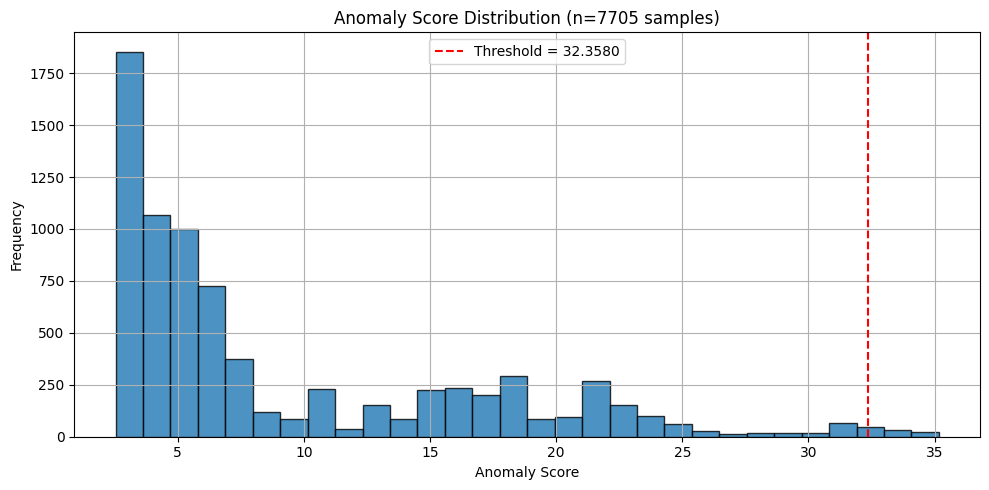

/var/folders/q7/_1jnd_xj7md5zz99bcgctd3w0000gp/T/ipykernel_35850/1026637421.py:312: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('viridis', sample_n)


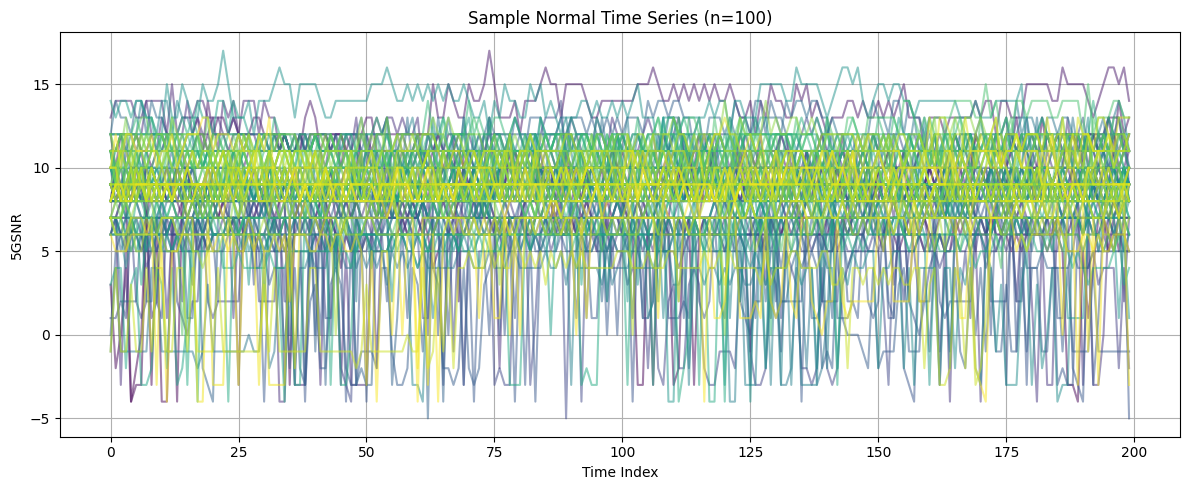

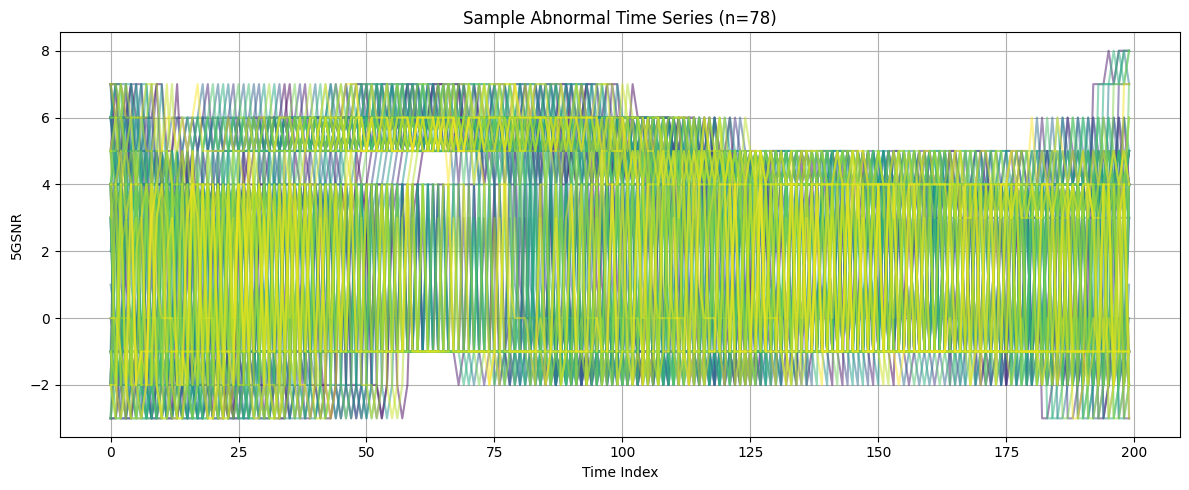

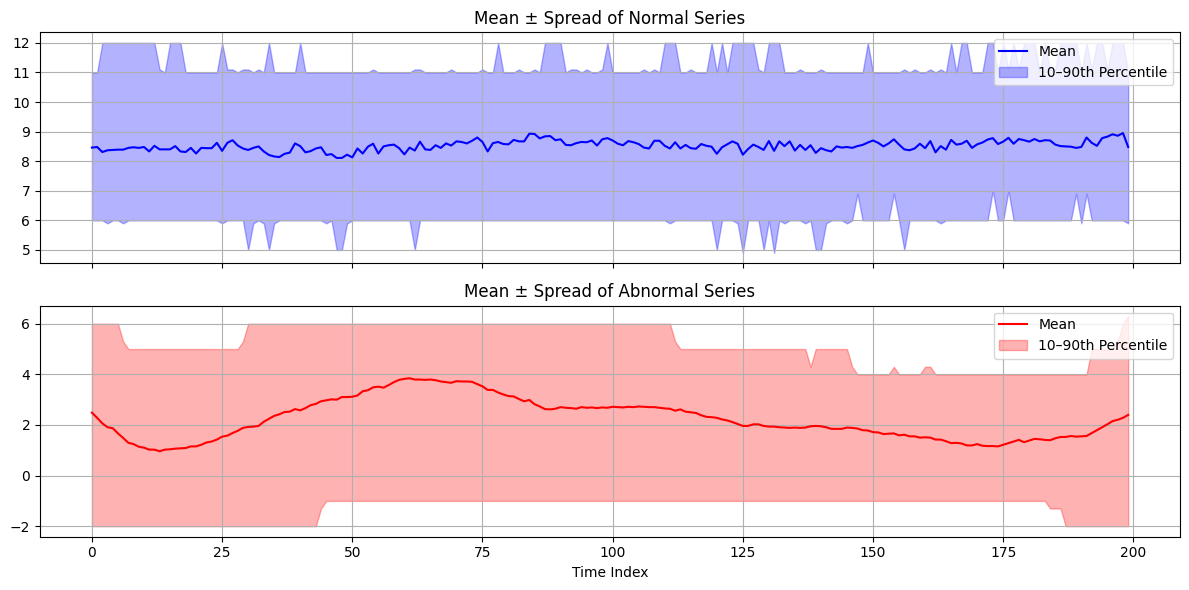

In [10]:

detector = MultiTimeSeriesAutoencoder(  df=df_pandas, 
                                        time_col="time", 
                                        feature=FEATURE_COL,
                                        slice_col = "slice_id",
                                        scaler = None)

detector.prepare()
detector.fit()

detector.plot_anomaly_score_distribution()
detector.plot_time_series_by_category("normal")
detector.plot_time_series_by_category("abnormal")
detector.plot_mean_and_spread()

# Sequential Bias-Reduction


In [13]:

df_scores = detector.get_anomaly_stats()
# ----------------------------
# Threshold helpers (pick one)
# ----------------------------
def quantile_threshold(scores: pd.Series, q: float = 0.995) -> float:
    """High-tail cut using a global quantile."""
    return float(scores.quantile(q))

def mad_threshold(scores: pd.Series, k: float = 3.5) -> float:
    """Robust z using MAD: keep scores with robust_z <= k."""
    med = scores.median()
    mad = (scores - med).abs().median() + 1e-12
    robust_z = (scores - med).abs() / (1.4826 * mad)
    # convert the z cutoff back to a score threshold (upper side)
    return float(med + k * 1.4826 * mad)

thr = quantile_threshold(df_scores['anomaly_score'], q=0.95)
# thr = mad_threshold(df_scores['anomaly_score'], k=3.5)

print(f"[Pass 1] Global threshold = {thr:.4f}")

# ----------------------------
# Join scores to raw data & drop high-score series
df_joined = df_pandas.merge(df_scores, on='slice_id', how='left')

df_joined['anomaly_score'] = df_joined['anomaly_score'].fillna(-np.inf)

bad_slices = set(df_scores.loc[df_scores['anomaly_score'] >= thr, 'slice_id'])
print(f"[Pass 1] Removing {len(bad_slices)} / {df_scores.shape[0]} series")

mask_keep_series = ~df_joined['slice_id'].isin(bad_slices)
df_clean_1 = df_joined.loc[mask_keep_series].copy()

[Pass 1] Global threshold = 23.3587
[Pass 1] Removing 386 / 7705 series


InnerAutoencoder(
  (activation): ReLU()
  (encoder): Sequential(
    (linear0): Linear(in_features=200, out_features=200, bias=True)
    (batch_norm0): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=200, out_features=32, bias=True)
    (batch_norm1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.2, inplace=False)
    (linear2): Linear(in_features=32, out_features=32, bias=True)
    (batch_norm2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu2): ReLU()
    (dropout2): Dropout(p=0.2, inplace=False)
    (linear3): Linear(in_features=32, out_features=200, bias=True)
    (batch_norm3): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu3): ReLU()
    (dropout3): Dropout(p=0.2, inplace=False)
  )


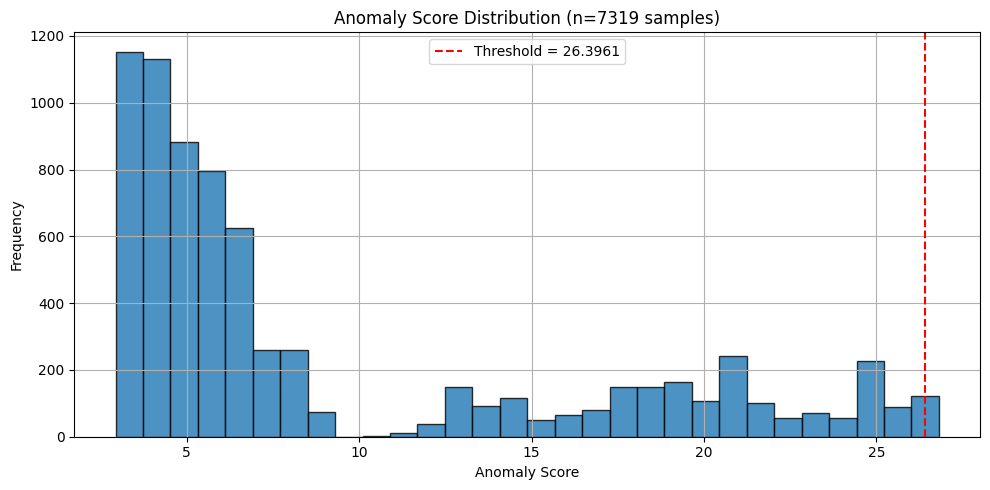

/var/folders/q7/_1jnd_xj7md5zz99bcgctd3w0000gp/T/ipykernel_35850/1026637421.py:312: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('viridis', sample_n)


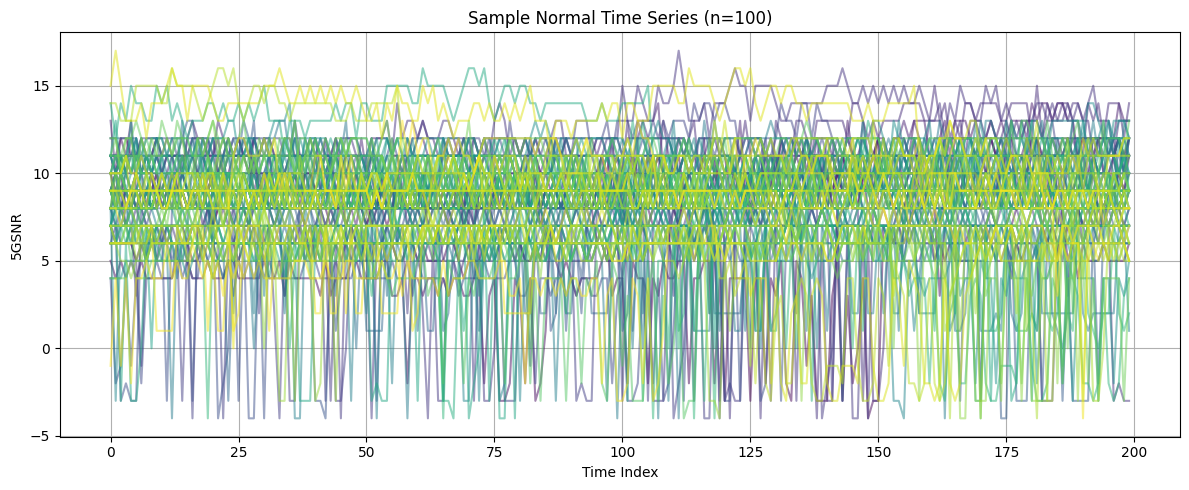

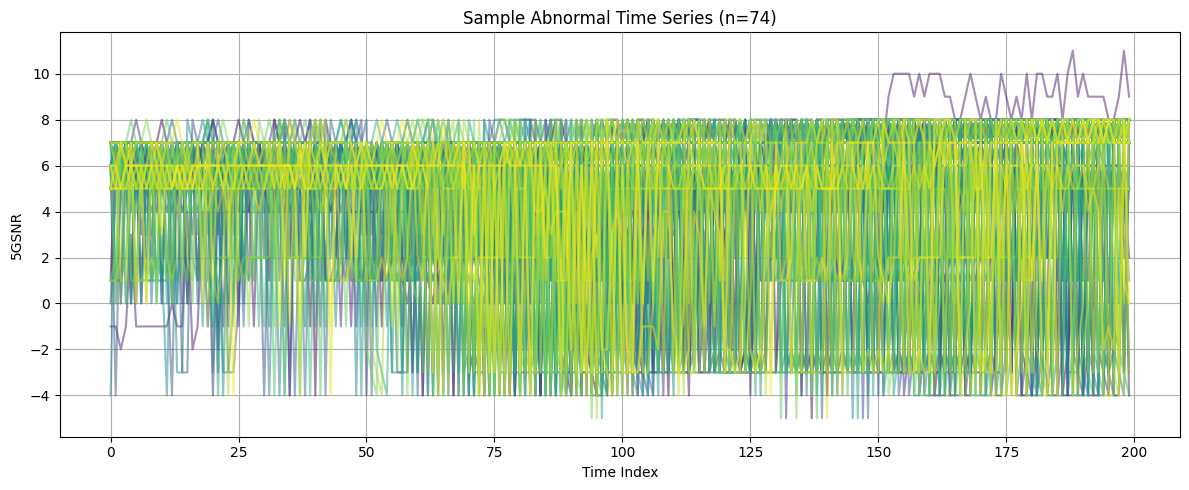

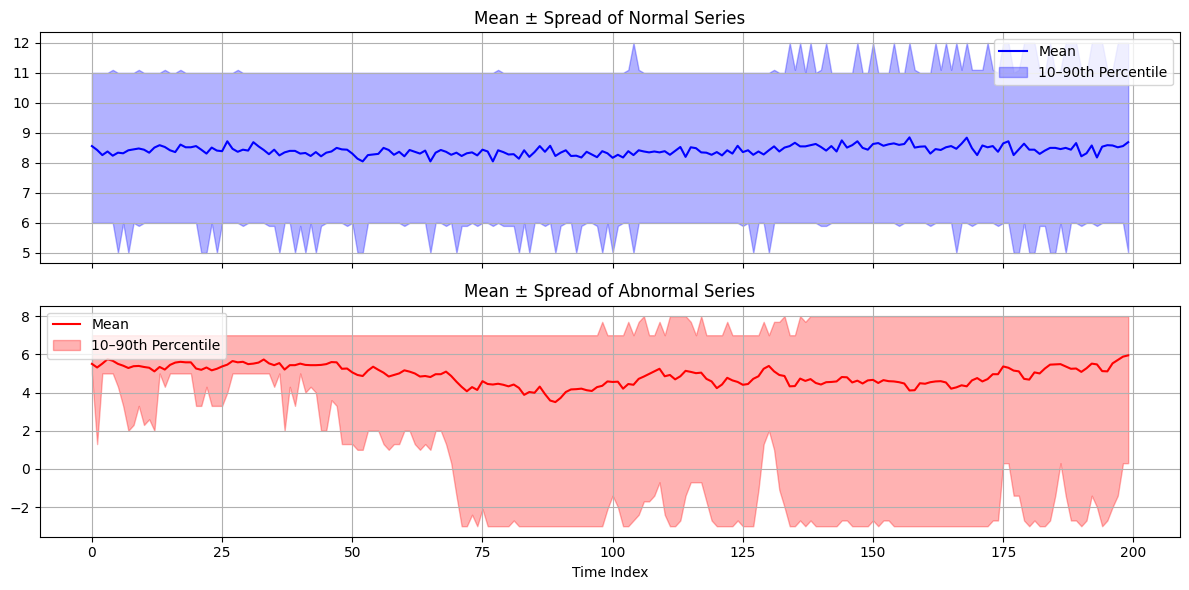

In [14]:

ae2 = MultiTimeSeriesAutoencoder(  df=df_clean_1[["slice_id","time",FEATURE_COL]], 
                                        time_col="time", 
                                        feature=FEATURE_COL,
                                        slice_col = "slice_id",
                                        scaler = None)

ae2.prepare()
ae2.fit()

ae2.plot_anomaly_score_distribution()
ae2.plot_time_series_by_category("normal")
ae2.plot_time_series_by_category("abnormal")
ae2.plot_mean_and_spread()

In [ ]:
import numpy as np
import pandas as pd

# Ensure FEATURE_COLS is a list
FEATURE_COLS = FEATURE_COL if isinstance(FEATURE_COL, (list, tuple)) else [FEATURE_COL]

# ---- helper: flatten ONE series and call predict_score_and_label ----
def score_one_flat(model, g: pd.DataFrame, feature_cols):
    """
    g: rows of a single slice_id, sorted by time
    Returns: scalar score, bool label (if provided)
    """
    # (T, F) -> flatten in time-major order to (1, T*F)
    X = g[feature_cols].to_numpy()
    X = X.reshape(1, -1)  # REQUIRED by your API

    res = model.predict_score_and_label(X)  # dict-like per your screenshot
    # Be tolerant to key names; grab the first numeric array as score
    score = None; label = None
    if isinstance(res, dict):
        # Try common keys first
        for k in ['anomaly_score', 'score', 'b', 'b ']:
            if k in res:
                score = np.asarray(res[k]).reshape(-1)[0]; break
        if score is None:
            # fallback: first numeric array value
            for v in res.values():
                try:
                    score = np.asarray(v).reshape(-1)[0]
                    break
                except Exception:
                    continue
        if 'is_outlier' in res:
            label = bool(np.asarray(res['is_outlier']).reshape(-1)[0])
    elif isinstance(res, (list, tuple)) and len(res) >= 1:
        score = np.asarray(res[0]).reshape(-1)[0]
        if len(res) >= 2:
            label = bool(np.asarray(res[1]).reshape(-1)[0])
    else:
        score = np.asarray(res).reshape(-1)[0]

    return float(score), (None if label is None else bool(label))

# ---- score ALL removed series, flattened ----
def score_removed_series_flat(model, df_series: pd.DataFrame, feature_cols):
    rows = []
    for sid, g in df_series.groupby("slice_id", sort=False):
        g = g.sort_values("time")
        s, lbl = score_one_flat(model, g, feature_cols)
        rows.append({"slice_id": sid, "score": s, "label": lbl})
    return pd.DataFrame(rows)

# Build the removed set (dirty_slices from your trimming step)
dirty_slices = list(bad_slices)
df_dirty_in = (df_pandas
               .loc[df_pandas['slice_id'].isin(dirty_slices),
                    ['slice_id','time'] + FEATURE_COLS]
               .sort_values(['slice_id','time'])
               .copy())

# ---- score with AE1 and AE2 ----
ae1_scores = score_removed_series_flat(detector, df_dirty_in, FEATURE_COLS)\
               .rename(columns={'score':'ae1_score','label':'ae1_label'})
ae2_scores = score_removed_series_flat(ae2,       df_dirty_in, FEATURE_COLS)\
               .rename(columns={'score':'ae2_score','label':'ae2_label'})

# ---- compare per series ----
cmp_df = (ae1_scores.merge(ae2_scores, on='slice_id', how='inner')
                    .assign(delta=lambda d: d['ae2_score'] - d['ae1_score'],
                            ratio=lambda d: (d['ae2_score']+1e-12)/(d['ae1_score']+1e-12))
                    .sort_values('delta', ascending=False))

print("Compared dirty series:", len(cmp_df))
print("Median Δ (AE2 - AE1):", float(cmp_df['delta'].median()))
print("Share AE2 > AE1:", float((cmp_df['delta'] > 0).mean()))

# (optional) quick sanity peek
display_cols = ['slice_id','ae1_score','ae2_score','delta','ratio','ae1_label','ae2_label']

cmp_df[display_cols].head(10)

,slice_id,ae1_score,ae2_score,delta,ratio,ae1_label,ae2_label
305,1752206460,33.342670,38.072085,4.729415,1.141843,True,True
306,1752206766,33.343633,38.070063,4.726430,1.141749,True,True
308,1752207377,33.537362,38.262254,4.724892,1.140884,True,True
307,1752207071,33.376285,38.099499,4.723214,1.141514,True,True
304,1752206156,33.156354,37.876734,4.720380,1.142367,True,True
300,1752204953,32.676847,37.390738,4.713891,1.144258,True,True
303,1752205854,32.939448,37.652903,4.713454,1.143095,True,True
297,1752204052,32.446381,37.158082,4.711701,1.145215,True,True
298,1752204352,32.471782,37.182674,4.710892,1.145076,True,True
296,1752203787,32.402665,37.112778,4.710113,1.145362,True,True


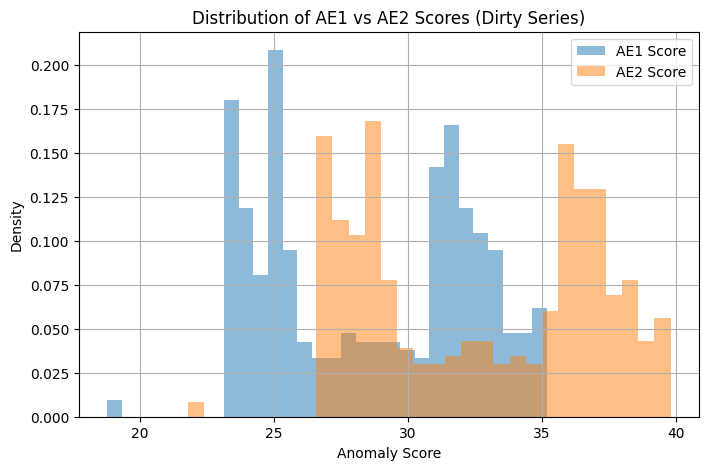

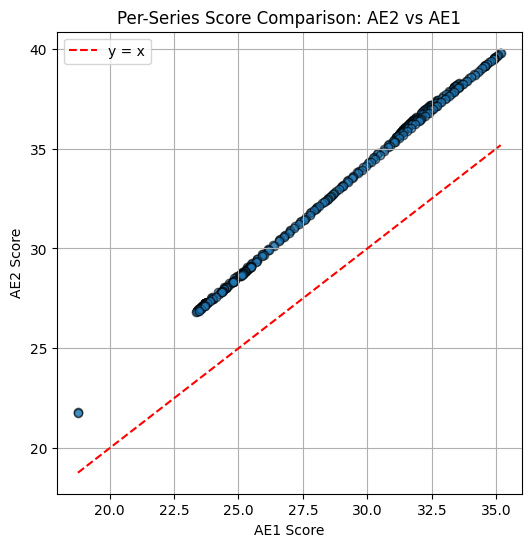

In [16]:

import matplotlib.pyplot as plt

# Plot the distributions of AE1 vs AE2 scores
plt.figure(figsize=(8, 5))
plt.hist(cmp_df['ae1_score'], bins=30, alpha=0.5, label='AE1 Score', density=True)
plt.hist(cmp_df['ae2_score'], bins=30, alpha=0.5, label='AE2 Score', density=True)
plt.xlabel('Anomaly Score')
plt.ylabel('Density')
plt.title('Distribution of AE1 vs AE2 Scores (Dirty Series)')
plt.legend()
plt.grid(True)
plt.show()

# Plot pairwise comparison (scatter plot)
plt.figure(figsize=(6, 6))
plt.scatter(cmp_df['ae1_score'], cmp_df['ae2_score'], alpha=0.6, edgecolor='k')
plt.plot([cmp_df['ae1_score'].min(), cmp_df['ae1_score'].max()],
         [cmp_df['ae1_score'].min(), cmp_df['ae1_score'].max()], 'r--', label='y = x')
plt.xlabel('AE1 Score')
plt.ylabel('AE2 Score')
plt.title('Per-Series Score Comparison: AE2 vs AE1')
plt.legend()
plt.grid(True)
plt.show()
